# 준비

In [34]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import losses
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.layers import Conv2D, Flatten, Dense, UpSampling2D, Reshape, Lambda, Input, Dropout

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## 데이터

In [3]:
BATCH_SIZE = 64
IMG_SHAPE = (28, 28, 1)

# mnist 데이터 셋 불러옴 
(X_train, __), (__, __) = fashion_mnist.load_data()

X_train = X_train[..., tf.newaxis].astype("float32")
X_train = X_train / 255.0

train_ds = tf.data.Dataset.from_tensor_slices(X_train).shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

## 데이터 확인

In [4]:
# 생성된 MNIST 이미지를 rowsxcols Grid로 보여주는 plot 함수 정의
def plot_imgs(path, imgs, rows, cols):

    fig = plt.figure(figsize=(rows, cols))
    fig.set_figheight(3)
    fig.set_figwidth(3)
    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.05, hspace=0.05)
   
    for i, img in enumerate(imgs):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')  
        
        plt.imshow(img.reshape((28, 28)), cmap='gray') 

    return fig

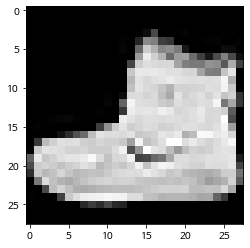

In [5]:
plt.imshow(X_train[0,:,:,0], cmap='gray')

# 모델

## Encoder

In [25]:
def build_encoder(input_shape, z_size, n_filters, n_layers):
    """Encoder구축
    
    Arguments:
        input_shape (int): 이미지의 shape
        z_size (int): 특징 공간의 차원 수
        n_filters (int): 필터 수
 
    """
    model = Sequential()
    model.add(Conv2D(n_filters, 3, activation='elu',input_shape=input_shape, padding='same'))
    model.add(Conv2D(n_filters, 3, padding='same'))
    for i in range(2, n_layers + 1):
        model.add(Conv2D(i*n_filters, 3, activation='elu', padding='same'))
        model.add(Conv2D(i*n_filters, 3, activation='elu', padding='same'))
  
    model.add(Conv2D(n_layers*n_filters, 3, padding='same'))
    model.add(Flatten())
    model.add(Dense(z_size))
    model.summary()
    return model

## Decoder

In [ ]:
  def build_gene(self, 
                 activation = 'selu',
                 last_activation='sigmoid',
                 kernel_size=5):

    h, w, ch = self.img_shape
    
    z = layers.Input(shape=[self.z_dim,], name='noise')

    y = layers.Dense(int(w/4)*int(h/4)*128)(z)
    y = layers.BatchNormalization()(y)
    
    # reshape
    y = layers.Reshape( [int(w/4),int(h/4),128] )(y)
    
    # to target size 1/4 -> 1/4 
    y = layers.Conv2DTranspose(128, kernel_size=5, padding='same', strides=1, activation=activation)(y)
    y = layers.BatchNormalization()(y)
    # to target size 1/4 -> 1/2
    y = layers.Conv2DTranspose(64, kernel_size=5, padding='same', strides=2, activation=activation)(y)
    y = layers.BatchNormalization()(y)
    # to target size 1/2 -> 1
    y = layers.Conv2DTranspose(ch, kernel_size=5, padding='same', strides=2, activation=last_activation)(y)
    
    return models.Model([z, c], y, name='Generator')

In [26]:
def build_decoder(output_shape, z_size, n_filters, n_layers):
    """Decoder 구축
    
    Arguments:
        output_shape (np.array): 이미지 shape
        z_size (int): 특징 공간의 차원 수
        n_filters (int): 필터 수
        n_layers (int): 레이어 수

    """
    h, w, ch = output_shape
    
    z = layers.Input(shape=[z_size,], )
    c = layers.Input(shape=[self.label_dim,])
    y = layers.concatenate([z, c])

    y = layers.Dense(int(w/4)*int(h/4)*128)(y)
    y = layers.BatchNormalization()(y)
    
    # reshape
    y = layers.Reshape( [int(w/4),int(h/4),128] )(y)
    
    # to target size 1/4 -> 1/4 
    y = layers.Conv2DTranspose(128, kernel_size=5, padding='same', strides=1, activation=activation)(y)
    y = layers.BatchNormalization()(y)
    # to target size 1/4 -> 1/2
    y = layers.Conv2DTranspose(64, kernel_size=5, padding='same', strides=2, activation=activation)(y)
    y = layers.BatchNormalization()(y)
    # to target size 1/2 -> 1
    y = layers.Conv2DTranspose(ch, kernel_size=5, padding='same', strides=2, activation=last_activation)(y)
    
    return Model([z, c], y)

## Generator ( decoder )

In [27]:
def build_generator(img_shape, z_size, n_filters, n_layers):
    decoder = build_decoder(img_shape, z_size, n_filters, n_layers)
    return decoder

## Discriminator ( encoder / decoder )

In [28]:
def build_discriminator(img_shape, z_size, n_filters, n_layers):
    encoder = build_encoder(img_shape, z_size, n_filters, n_layers)
    decoder = build_decoder(img_shape, z_size, n_filters, n_layers)
    return keras.models.Sequential((encoder, decoder))

## Discriminator 학습

In [29]:
def build_discriminator_trainer(discriminator):
    img_shape = discriminator.input_shape[1:]
    real_inputs = Input(img_shape)
    fake_inputs = Input(img_shape)
    real_outputs = discriminator(real_inputs)
    fake_outputs = discriminator(fake_inputs)

    return Model(
        inputs=[real_inputs, fake_inputs],
        outputs=[real_outputs, fake_outputs]
    )

## 손실함수

In [30]:
def build_generator_loss(discriminator):
    # discriminator를 사용해서 손실 함수 정의
    def loss(y_true, y_pred):
        # y_true는 더미
        reconst = discriminator(y_pred)
        return mean_absolute_error(reconst, y_pred)
    return loss

## 수렴 판정 함수

In [31]:
def measure(real_loss, fake_loss, gamma):
    return real_loss + np.abs(gamma*real_loss - fake_loss)

# 학습

In [32]:
n_filters = 64 #  필터 수
n_layers = 3 # 레이어 수
z_size = 32  #  특징 공간의 차원

generator = build_generator(IMG_SHAPE, z_size, n_filters, n_layers)
discriminator = build_discriminator(IMG_SHAPE, z_size, n_filters, n_layers)
discriminator_trainer = build_discriminator_trainer(discriminator)

# 초기 학습률(Generator)
g_lr = 0.0001
generator_loss = build_generator_loss(discriminator)
generator.compile(loss=generator_loss, optimizer=Adam(g_lr))

# 초기 학습률(Discriminator)
# k_var는 수치(일반 변수)
k_var = 0.0
# k : Keras(TensorFlow) Variable
k = K.variable(k_var)

d_lr = 0.0001

discriminator_trainer.compile(loss=[ mean_absolute_error, mean_absolute_error],loss_weights=[1., -k], optimizer=Adam(d_lr))

generator.summary()
# discriminator.layers[1]은 디코더를 나타냄
discriminator.layers[1].summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 192)       221376    
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 192)       331968    
                                                                 
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 32)               

{'Epoch:': 0, 'k': 0.14406787, 'measure': 0.14339626161381602, 'real_loss': 0.07506827265024185, 'fake_loss': 0.006740283686667681}
1/1 [==============================] - 0s 122ms/step


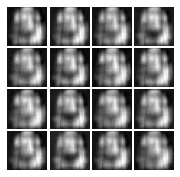

{'Epoch:': 1, 'k': 0.2012068, 'measure': 0.06448391498997808, 'real_loss': 0.06929107755422592, 'fake_loss': 0.009614325128495693}
1/1 [==============================] - 0s 13ms/step


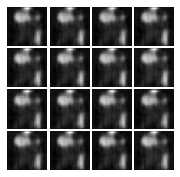

{'Epoch:': 2, 'k': 0.25057, 'measure': 0.03429803950712085, 'real_loss': 0.05454738810658455, 'fake_loss': 0.006200657691806555}
1/1 [==============================] - 0s 13ms/step


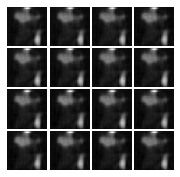

{'Epoch:': 3, 'k': 0.29708543, 'measure': 0.025584115064702928, 'real_loss': 0.053397685289382935, 'fake_loss': 0.004458910319954157}
1/1 [==============================] - 0s 12ms/step


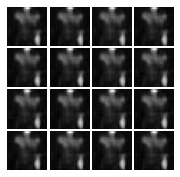

{'Epoch:': 4, 'k': 0.34214622, 'measure': 0.019744623731821776, 'real_loss': 0.05177812650799751, 'fake_loss': 0.0048331343568861485}
1/1 [==============================] - 0s 13ms/step


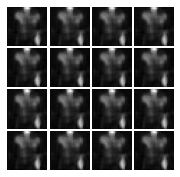

{'Epoch:': 5, 'k': 0.38611838, 'measure': 0.018195691828926403, 'real_loss': 0.05790591612458229, 'fake_loss': 0.006637681275606155}
1/1 [==============================] - 0s 14ms/step


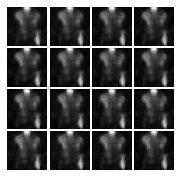

{'Epoch:': 6, 'k': 0.42939988, 'measure': 0.015836885664612055, 'real_loss': 0.0582430362701416, 'fake_loss': 0.005627872887998819}
1/1 [==============================] - 0s 13ms/step


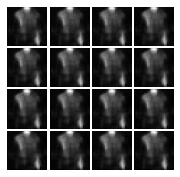

{'Epoch:': 7, 'k': 0.47225276, 'measure': 0.011858248908538371, 'real_loss': 0.05083660036325455, 'fake_loss': 0.006807209458202124}
1/1 [==============================] - 0s 13ms/step


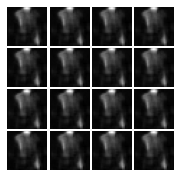

{'Epoch:': 8, 'k': 0.5144773, 'measure': 0.010273856680012412, 'real_loss': 0.04890577122569084, 'fake_loss': 0.0053468323312699795}
1/1 [==============================] - 0s 13ms/step


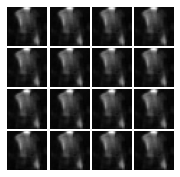

{'Epoch:': 9, 'k': 0.5563631, 'measure': 0.008584000030532479, 'real_loss': 0.044710513204336166, 'fake_loss': 0.00358102610334754}
1/1 [==============================] - 0s 13ms/step


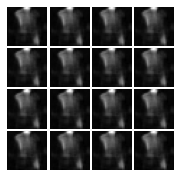

{'Epoch:': 10, 'k': 0.5975266, 'measure': 0.00827920525758104, 'real_loss': 0.047945622354745865, 'fake_loss': 0.004819986876100302}
1/1 [==============================] - 0s 14ms/step


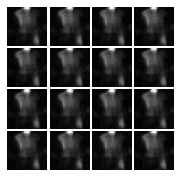

{'Epoch:': 11, 'k': 0.6382131, 'measure': 0.008165611846682927, 'real_loss': 0.05133281275629997, 'fake_loss': 0.004678283352404833}
1/1 [==============================] - 0s 5ms/step


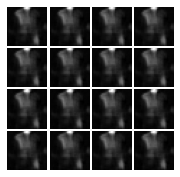

KeyboardInterrupt: 

In [15]:
# k의 갱신에 이용할 파라미터
GAMMA = 1
Lambda = 0.001

EPOCHS = 100

# 모델과 확인용 생성 이미지를 저장할 폴더
IMG_SAVE_DIR = "tmp"
# 확인용으로 4x4 개의 이미지를 생성
IMG_SAMPLE_SHAPE = (4, 4)
N_IMG_SAMPLES = np.prod(IMG_SAMPLE_SHAPE)

# 저장할 폴더가 없다면 생성
os.makedirs(IMG_SAVE_DIR, exist_ok=True)

# 샘플이미지용 랜덤 시드
sample_seeds = np.random.uniform(-1, 1, (N_IMG_SAMPLES, z_size))

history = []
logs = []

for epoch in range(EPOCHS):

    #임의의 값(noise) 생성, 잠재변수의 input으로 사용할 noise를 균등분포(Uniform Distribution)에서 BATCH_SIZE만큼 샘플링
    z_g = np.random.uniform(-1, 1,
                            (BATCH_SIZE, z_size))  # 균등 분포 -1과 1사이에 랜덤값 추출
    z_d = np.random.uniform(-1, 1, (BATCH_SIZE, z_size))

    for batch in train_ds:
        # 생성 이미지(구분자의 학습에 이용), z_g 입력받아 가짜 이미지 생성
        g_pred = generator.predict(z_d, verbose=0)

        # generator를 1스텝 학습시킨다
        generator.train_on_batch(z_g, batch)

        # discriminator를 1스텝 학습시킨다
        _, real_loss, fake_loss = discriminator_trainer.train_on_batch(
            [batch, g_pred], [batch, g_pred])

        # k 를 갱신, generator & discriminator loss 균형맞춤. discriminator가 얼마나  fake images에 집중할 것인지 컨트롤. 매 batch마다 업데이트.
        k_var += Lambda * (GAMMA * real_loss - fake_loss)
        K.set_value(k, k_var)

        # g_measure 을 계산하기 위한 loss 저장
        history.append({'real_loss': real_loss, 'fake_loss': fake_loss})

    measurement = measure(history[-1]['real_loss'], history[-1]['fake_loss'], GAMMA) / (epoch+1)
    logs.append({
        'Epoch:': epoch,
        'k': K.get_value(k),
        'measure': measurement,
        'real_loss': real_loss,
        'fake_loss': fake_loss
    })
    print(logs[-1])

    # 생성된 이미지 저장 및 보이기
    img_path = '{}/generated_{}.png'.format(IMG_SAVE_DIR, epoch)
    fig = plot_imgs(img_path,
                    generator.predict(sample_seeds),
                    rows=IMG_SAMPLE_SHAPE[0],
                    cols=IMG_SAMPLE_SHAPE[1])
    plt.savefig(img_path, bbox_inches='tight')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 13ms/step


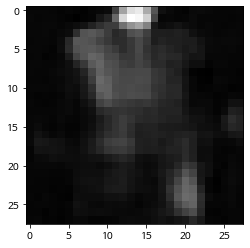

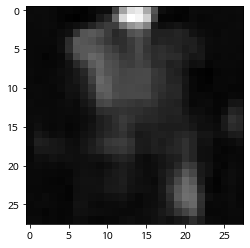

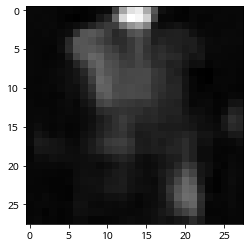

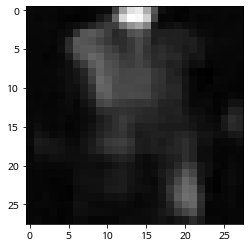

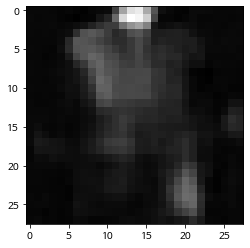

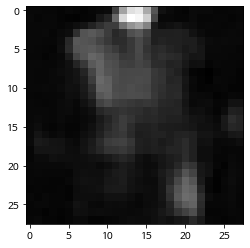

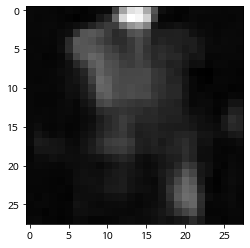

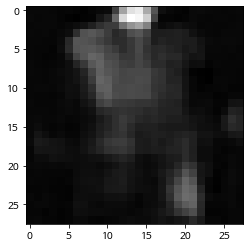

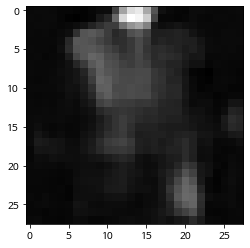

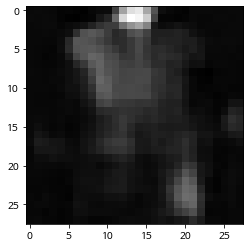

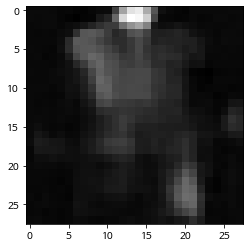

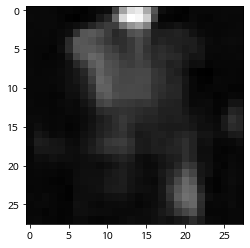

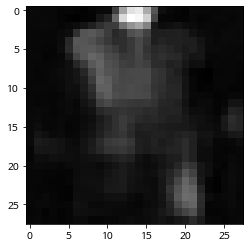

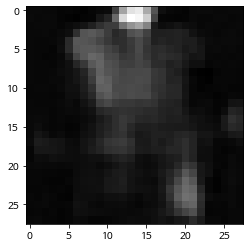

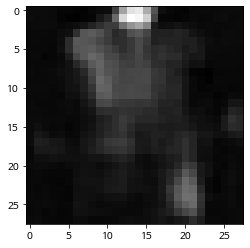

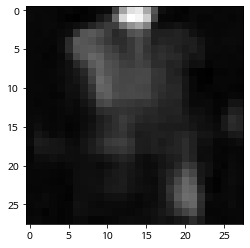

In [24]:
sample_seeds = np.random.uniform(-1, 1, (N_IMG_SAMPLES, z_size))
pred_sample = generator.predict(sample_seeds)

for i in range(16):
    plt.imshow(pred_sample[i][:,:,0], cmap='gray')
    plt.show()